In [5]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [7]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [8]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 340kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.94MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.01MB/s]


In [9]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


Architecture

In [23]:
import torch.nn as nn
import torch.nn.functional as F

dropout_value = 0.05 # Reduced dropout for a more compact model

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # CONVOLUTION BLOCK 1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26, RF = 3

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24, RF = 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12, RF = 6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 12, RF = 6

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10, RF = 10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8, RF = 14
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # output_size = 1, RF = 28
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) # output_size = 1, RF = 28

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.gap(x)
        x = self.convblock6(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [24]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
             ReLU-11            [-1, 8, 12, 12]               0
           Conv2d-12           [-1, 16, 10, 10]           1,152
             ReLU-13           [-1, 16, 10, 10]               0
      BatchNorm2d-14           [-1

In [25]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [26]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.18002314865589142 Batch_id=468 Accuracy=78.49: 100%|██████████| 469/469 [00:07<00:00, 61.71it/s]



Test set: Average loss: 0.2130, Accuracy: 9420/10000 (94.20%)

EPOCH: 1


Loss=0.09276146441698074 Batch_id=468 Accuracy=96.28: 100%|██████████| 469/469 [00:07<00:00, 62.13it/s] 



Test set: Average loss: 0.1135, Accuracy: 9683/10000 (96.83%)

EPOCH: 2


Loss=0.1555977314710617 Batch_id=468 Accuracy=97.18: 100%|██████████| 469/469 [00:07<00:00, 61.84it/s]  



Test set: Average loss: 0.1132, Accuracy: 9644/10000 (96.44%)

EPOCH: 3


Loss=0.11630695313215256 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:07<00:00, 61.98it/s] 



Test set: Average loss: 0.0581, Accuracy: 9834/10000 (98.34%)

EPOCH: 4


Loss=0.05820631980895996 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:07<00:00, 61.82it/s] 



Test set: Average loss: 0.0512, Accuracy: 9848/10000 (98.48%)

EPOCH: 5


Loss=0.038538116961717606 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:07<00:00, 61.50it/s]



Test set: Average loss: 0.0452, Accuracy: 9866/10000 (98.66%)

EPOCH: 6


Loss=0.020820284262299538 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:07<00:00, 61.05it/s]



Test set: Average loss: 0.0400, Accuracy: 9879/10000 (98.79%)

EPOCH: 7


Loss=0.07840794324874878 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:07<00:00, 61.38it/s] 



Test set: Average loss: 0.0495, Accuracy: 9848/10000 (98.48%)

EPOCH: 8


Loss=0.10909909754991531 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:07<00:00, 60.44it/s] 



Test set: Average loss: 0.0390, Accuracy: 9871/10000 (98.71%)

EPOCH: 9


Loss=0.016750916838645935 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:07<00:00, 61.32it/s]



Test set: Average loss: 0.0416, Accuracy: 9875/10000 (98.75%)

EPOCH: 10


Loss=0.03711545467376709 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:07<00:00, 61.15it/s] 



Test set: Average loss: 0.0408, Accuracy: 9869/10000 (98.69%)

EPOCH: 11


Loss=0.05104872211813927 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:07<00:00, 61.53it/s] 



Test set: Average loss: 0.0400, Accuracy: 9879/10000 (98.79%)

EPOCH: 12


Loss=0.06580494344234467 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:07<00:00, 60.62it/s] 



Test set: Average loss: 0.0330, Accuracy: 9899/10000 (98.99%)

EPOCH: 13


Loss=0.03314012661576271 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:07<00:00, 60.55it/s] 



Test set: Average loss: 0.0341, Accuracy: 9892/10000 (98.92%)

EPOCH: 14


Loss=0.017308147624135017 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:07<00:00, 60.84it/s]



Test set: Average loss: 0.0328, Accuracy: 9901/10000 (99.01%)



In [18]:
t = [t_items.item() for t_items in train_losses]

In [31]:
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 1.0, 'Test Accuracy')

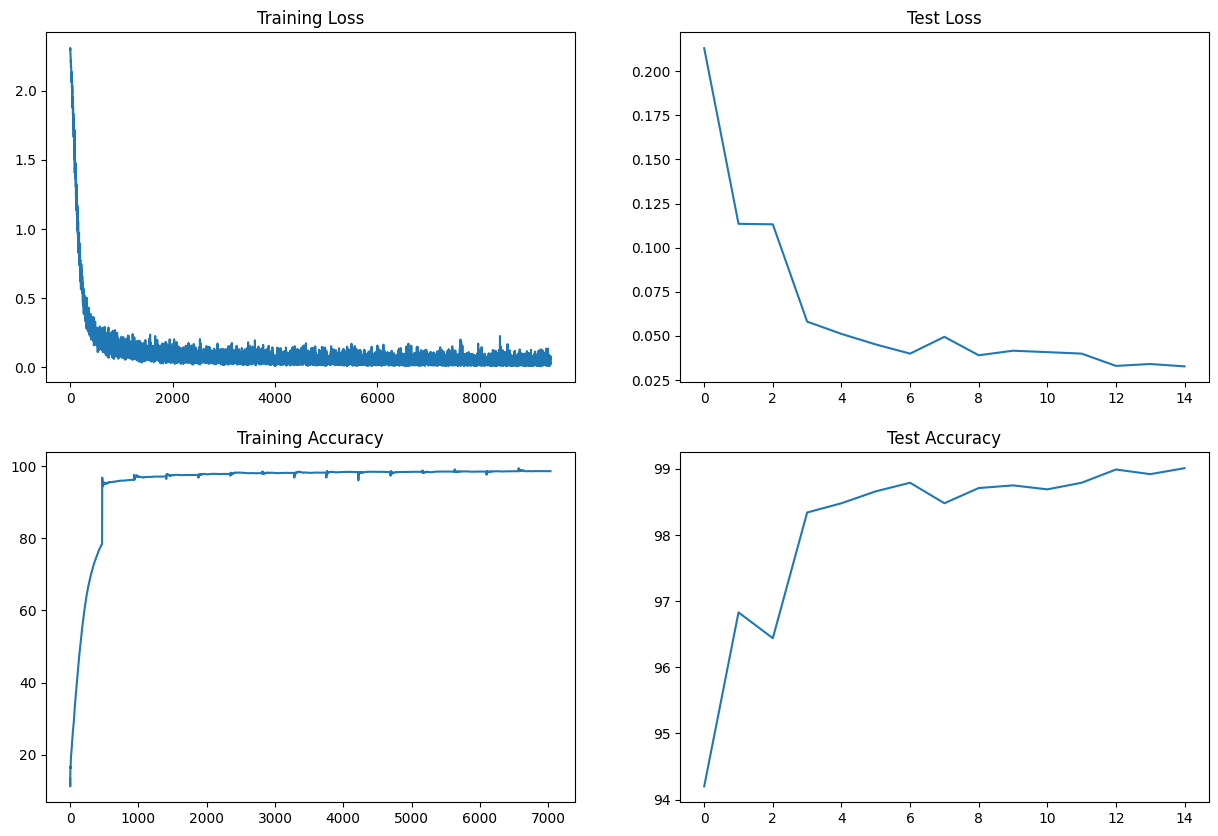

In [33]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
